In [4]:
 # checking for the GPU we get for this model 
 !nvidia-smi
 # installing the latest version of tensorflow GPU
 !pip install tensorflow-gpu >> /dev/null
 !pip install --upgrade grpcio >> /dev/null
 # show progress bars while installation and downloading 
 !pip install tqdm  >> /dev/null
 # the original implementation given in research paper is not compatible with TensorFlow 2. The bert-for-tf2 package solves this issue.
 !pip install bert-for-tf2 >> /dev/null
 # install sentencepiece tokenizer for making tokens out of sentences
 !pip install sentencepiece >> /dev/null
 # making directories, math operations
 

Mon May  2 14:23:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |      0MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

�� �穫��� ��� �夘� �� �⩞ �� �����婜� ��� ��������⤞ �������� �婡��.
�� �穫��� ��� �夘� �� �⩞ �� �����婜� ��� ��������⤞ �������� �婡��.
�� �穫��� ��� �夘� �� �⩞ �� �����婜� ��� ��������⤞ �������� �婡��.
�� �穫��� ��� �夘� �� �⩞ �� �����婜� ��� ��������⤞ �������� �婡��.
�� �穫��� ��� �夘� �� �⩞ �� �����婜� ��� ��������⤞ �������� �婡��.


In [6]:
import os
import math
import datetime
# show progress bars in the notebook itself
from tqdm import tqdm
 # data manipulation in dataframe and array
import pandas as pd
import numpy as np
 # keras implementation
import tensorflow as tf
from tensorflow import keras
 # import the bert model and model layer 
 # also the bert tokenizer for text pre processing
import bert
 # we can change the layers downloaded from here
from bert import BertModelLayer
 # useful for loading necessary files from data
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer
 # data visualization at the time of data import and model metrics
import seaborn as sns
 # we can set the parameters for each plot 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc
 # model metrics to be defined 
from sklearn.metrics import confusion_matrix, classification_report
 # showing the plots in the notebook itself
%matplotlib inline
 # retina is a style shape
%config InlineBackend.figure_format='retina'
 # setting the visualizing settings first hand
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# getting the colors we need for plots
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
 # define the color palette
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
 # size can be set accordingly
rcParams['figure.figsize'] = 12, 8
 # generating pseudo random numbers
RANDOM_SEED = 42
 # np arrays , tensors
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)  

In [7]:
 # downloading the data from google drives which is in now form of csv files having two columns of sentences and it's intent
 # earlier the data was in form of json file but after a little bit of data pre processing , we are using it in the form of csv files 
import gdown    
!gdown --id 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown --id 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown --id 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv


C:\Users\nickr\anaconda3\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: c:\Users\nickr\OneDrive\Υπολογιστής\Repositories\Greek-Bert\Scripts\train.csv

  0%|          | 0.00/799k [00:00<?, ?B/s]
 66%|██████▌   | 524k/799k [00:00<00:00, 1.77MB/s]
100%|██████████| 799k/799k [00:00<00:00, 2.14MB/s]
C:\Users\nickr\anaconda3\lib\site-packages\gdown\cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: c:\Users\nickr\OneDrive\Υπολογιστής\Repositories\Greek-Bert\Scripts\valid.csv

  0%|          | 0.00/43.3k [00:00<?, ?B/s]
100%|██████████| 43.3k/43.3k [00:00

In [8]:
os.getcwd()

'c:\\Users\\nickr\\OneDrive\\Υπολογιστής\\Repositories\\Greek-Bert\\Scripts'

C:\Users\nickr\AppData\Local\Temp\ipykernel_9484\1716419551.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train = train.append(valid).reset_index(drop=True)
C:\Users\nickr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


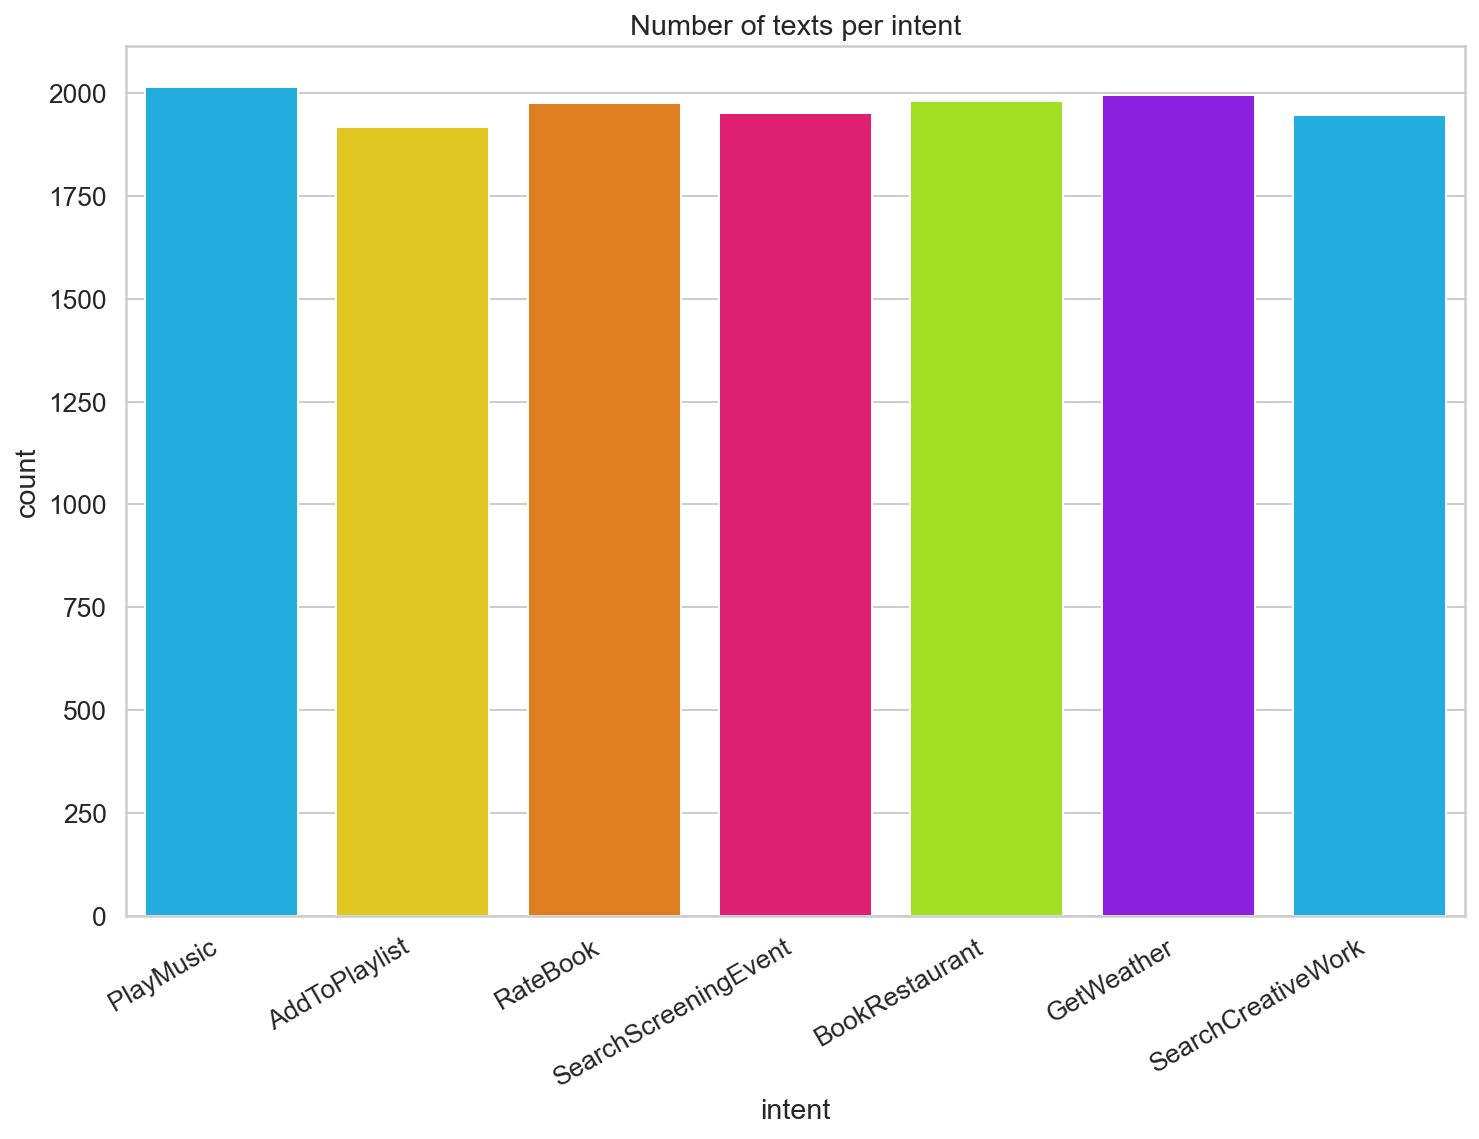

In [9]:
# making separate dataframes for the three files 
# which are already pre processed
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")
 # appending the valid df to train df to make a bigger data
train = train.append(valid).reset_index(drop=True)
 # training df has 13784 no. of records
 # 13,784 data points with intents
train.shape
train.head()
 # let's check how the datset looks , if it is imbalanced or not
 # making a chart to see how many texts are for each of the seven intents
chart = sns.countplot(train.intent, palette=HAPPY_COLORS_PALETTE)
 # setting title of the chart
plt.title("Number of texts per intent")
 # setting labels to the bottom at an angle of 30 degrees
chart.set_xticklabels(chart.get_xticklabels(), rotation=30, horizontalalignment='right'); 

In [11]:
import wget
import unzip
import mv
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
# download the pre trained bert model in the form of a zip file
#!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
 # unzipping the file having model
 # this is having all the checkpoints , vocab.text for tokenizer , configurations for model
!unzip uncased_L-12_H-768_A-12.zip
 # make a folder named model for moving all the stuff 
os.makedirs("model", exist_ok=True)
 # moving the stuff from bert to model folder 
!mv uncased_L-12_H-768_A-12/ model
 # specify the model name 
bert_model_name="uncased_L-12_H-768_A-12"
 # specify where the  check point directory is 
bert_ckpt_dir = os.path.join("model/", bert_model_name)
 # specify the checkpoint file itself
bert_ckpt_file = os.path.join(bert_ckpt_dir, "bert_model.ckpt")
 # specify the configuration file 
bert_config_file = os.path.join(bert_ckpt_dir, "bert_config.json") 

ModuleNotFoundError: No module named 'ut.util'

In [14]:
 # pre processing in which we have to use the tokenizer
 # for getting tokens so that we can feed the model
 # creating a class which is a little generic for doing our tokenizing process
class IntentDetectionData:
   # we had two columns to which have given names according to use
   DATA_COLUMN = "text"
   LABEL_COLUMN = "intent"
   '''
   creating constructor having train data , test data , tokenzier , max_seq_len because NLP tasks work on a fixed number of elements 
   the data set we are having has different lengths of sequences , that's why we have to do same length for all  , either we can cut the sequence 
   lengths to some minimal point or we can add padding up to the maximum existing 
   ''' 
def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=192):
    self.tokenizer = tokenizer
     # setting initial to 0
    self.max_seq_len = 0
    self.classes = classes
     '''
     create train_X and train_Y 
     train_X will have the vectors , train_Y will have the target labels 
     same we will do for the testing part
     '''
    train, test = map(lambda df: df.reindex(df[IntentDetectionData.DATA_COLUMN].str.len().sort_values().index), [train, test])
     # we gave to set the variables to which we can map values using the above function
    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])
    print("max seq_len", self.max_seq_len)
    # setting the actual value to max_seq_len
    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    # adding padding in the following line
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])
def _prepare(self, df):
    # initialising two empty arrays
    x, y = [], []
    # iterate over each row and use tqdm to visualize that
    for _, row in tqdm(df.iterrows()):
      # extracting the seq. and labels
      text, label = row[IntentDetectionData.DATA_COLUMN], row[IntentDetectionData.LABEL_COLUMN]
      # create an object named token and initialise it
      tokens = self.tokenizer.tokenize(text)
      # adding two special tokens which will surround each token 
      # from front and back 
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      # convert the token ids to numbers using a helper
      # function already provided for feeding
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      # calculate the length of seq. by taking max. 
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      # appends the token ids to x
      x.append(token_ids)
      # indexes of labels to the y
      y.append(self.classes.index(label))
    # returning these in the form of nparrays
    return np.array(x), np.array(y)
    # takes the ids and not the tokens itself
def _pad(self, ids):
    # create an empty list again
    x = []
    # iterating over each id
    for input_ids in ids:
      # we have to cut the longer seq. , self.max_seq_len - 2 
      # because two positions are reserved for the special tokens as mentioned before
      input_ids = input_ids[:min(len(input_ids), self.max_seq_len - 2)]
      # adding padding to the smaller ones
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      # appending  
      x.append(np.array(input_ids))
    return np.array(x)
# use tokenizer which expects a vocabulary file, 
# we have this file already in our data
tokenizer = FullTokenizer(vocab_file=os.path.join(bert_ckpt_dir, "vocab.txt"))
# trying the tokenizer , lower cases everything , good tokenizer as it preserves punctuations
tokenizer.tokenize("I can't wait to visit India again!")
# example of tokenization and then converting them to token ids which are basically numbers for our model to understand 
tokens = tokenizer.tokenize("I can't wait to visit India again!")
tokenizer.convert_tokens_to_ids(tokens) 

IndentationError: unexpected indent (2670729725.py, line 18)